##Caption Generation

###Script


Script to clone the base from github and retain only the necessary directory

In [0]:
%%shell
git clone https://github.com/ufrpe-mineracao-textos/projeto-de-mineracao-20192-chart-minerators.git
mv /content/projeto-de-mineracao-20192-chart-minerators/base ./base
mv /content/projeto-de-mineracao-20192-chart-minerators/scripts/scriptMenor.sh ./scriptMenor.sh
chmod 777 scriptMenor.sh
rm -rf /content/projeto-de-mineracao-20192-chart-minerators/

Cloning into 'projeto-de-mineracao-20192-chart-minerators'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 946 (delta 0), reused 2 (delta 0), pack-reused 943
Receiving objects: 100% (946/946), 107.49 MiB | 10.57 MiB/s, done.
Resolving deltas: 100% (466/466), done.


###Import

Required Imports and Downloads

In [0]:
import cv2
import nltk
import subprocess
import numpy as np
from os import listdir
from pickle import load, dump
from keras.models import Model
import matplotlib.pyplot as plt
from unicodedata import normalize
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint
from google.colab.patches import cv2_imshow
from keras.preprocessing.text import Tokenizer
from nltk.translate.bleu_score import corpus_bleu
from keras.utils import to_categorical,  plot_model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.vgg19 import VGG19, preprocess_input
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, GRU, SimpleRNN

nltk.download('rslp')
nltk.download('stopwords')


Using TensorFlow backend.


[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

###Extract features

#####Functions

Extract features from each photo in the directory

In [0]:
# load the model
def load_the_model():
	model = VGG19()
	model.layers.pop()
	model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
	return model

# extract features
def extract_features(directory_main):
	# load the model
	model = load_the_model()

  # {image_path:feature}
	features = dict()
 	# extract features from each photo
	for directory in listdir(directory_main):
		directory = directory_main+directory
		print('>{}'.format(directory))
		features_temp = dict()
		for name in listdir(directory):
			filename = directory + '/' + name
			# read image
			image=cv2.imread(filename)
			# resize  data for the model
			image = cv2.resize(image,(224,224))
			# reshape data for the model
			image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
			# prepare the image for the VGG model
			image = preprocess_input(image)
			# get features
			feature = model.predict(image, verbose=1)
			# get image id
			image_id = name.split('.')[0]
			relative_filename = './'+ directory.split('/')[4] + '/' + image_id
			# store feature
			features_temp[relative_filename] = feature
			print(relative_filename)
		features.update(features_temp)
	return features

# extract features from photo in the directory
def extract_features_one_photo(filename):
	# load the model
	model = load_the_model()
	# read image
	image=cv2.imread(filename)
	# resize  data for the model
	image = cv2.resize(image,(224,224))
	# reshape data for the model
	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	# prepare the image for the VGG model
	image = preprocess_input(image)
	# get features
	feature = model.predict(image, verbose=1)
	return feature

#####Run

Run extraction features


In [0]:
directory = '/content/base/Imagens/'
features = extract_features(directory)
print('Extracted Features: %d' % len(features))
# save to file
dump(features, open('features.pkl', 'wb'))





574717952/574710816 [==============================] - 35s 0us/step






>/content/base/Imagens/Peppe
1/1 [==============================] - 4s 4s/step
./Peppe/imagem6
1/1 [==============================] - 0s 37ms/step
./Peppe/imagem29
1/1 [==============================] - 0s 34ms/step
./Peppe/imagem24
1/1 [==============================] - 0s 32ms/step
./Peppe/imagem2
1/1 [==============================] - 0s 32ms/step
./Peppe/imagem13
1/1 [==============================] - 0s 32ms/step
./Peppe/imagem21
1/1 [==============================] - 0s 35ms/step
./Peppe/imagem4
1/1 [==============================] - 0s 31ms/step
./Peppe/imagem23
1/1 [==============================] - 0s 31ms/step
./Peppe/imagem25
1/1 [==============================] - 0s 33ms/step
./Peppe/imagem47
1/1 [==============================] - 0s 31ms/step
./Peppe/imagem8
1/1 [==============================] - 0s 32ms/step
./Peppe/imagem40
1/1 [==============================] - 0s 31ms/step
./Peppe/imagem20
1/

###Prepare text

#####Functions

Prepare text to obtain the minimal vocabulary as possible avoind problem with duplicated word just with some differences

In [0]:
# load captions
def load_doc(filename):
	file = open(filename, 'r')
	text = file.read()
	file.close()
	return text

# map image to caption
def load_captions(doc):
  mapping = dict()
  for line in doc.split('\n'):
    # there's a bug in the way that the document was creadted 'case the 
    # this was made from different OS and different file editor.
    # and there's anothe that exist different number of '#' but the normal
    # is to exit only  2 '#'
    if line.count("#")==2:
      image_id, image_desc, classe = line.split('#')
    elif line.count("#")==3:
      image_id, image_desc, classe,_ = line.split('#')
    elif line.count("#")==4:
      image_id, image_desc, classe,_,_ = line.split('#')
    else:
      continue
    if image_id not in mapping:
        mapping[image_id] = list()
    mapping[image_id].append(image_desc)
  return mapping

# make stamming
def Stemming(captions):
  stemmer = nltk.stem.RSLPStemmer()
  palavras=[]
  for key,value in captions.items():
    for w in value[0].split():
      palavras.append(stemmer.stem(w))
    captions[key]=[" ".join(palavras)]
    palavras=[]

# remove stopwords
def RemoviStopWords(captions):
  palavras=[]
  for key,value in captions.items():  
    instancia = value[0].lower()
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    palavras = [i for i in instancia.split() if not i in stopwords]
    captions[key]=[" ".join(palavras)]
    palavras=[]

# remove acents
def remover_acentos(captions):
  for key,value in captions.items():  
    captions[key]=normalize('NFKD', value[0]).encode('ASCII', 'ignore').decode('ASCII')

# convert the loaded captions into a vocabulary of words
def to_vocabulary(captions):
  # build a set of all description strings
  all_desc = set()
  for key,value in captions.items():
    for w in value.split():
      all_desc.update({w})
  return all_desc

# save captions to file, one per line
def save_captions(captions, filename):
  lines = list()
  for key, desc_list in captions.items():
    lines.append(key + ' ' + desc_list)
  data = '\n'.join(lines)
  file = open(filename, 'w')
  file.write(data)
  file.close()

#####Run

Run all functions to prepare text and create the vocabulary

In [0]:
# load file
filename = '/content/base/Legendas/legenda.txt'
doc = load_doc(filename)

# parse captions
captions = load_captions(doc)
print('Loaded: %d ' % len(captions))

# clear captions
Stemming(captions)
RemoviStopWords(captions)
remover_acentos(captions)

# summarize vocabulary
vocabulary = to_vocabulary(captions)
print('Vocabulary Size: %d' % len(vocabulary))

# save captions
save_captions(captions, 'captions.txt')

Loaded: 186 
Vocabulary Size: 1266


#####Plot

Plot and save wordcloud

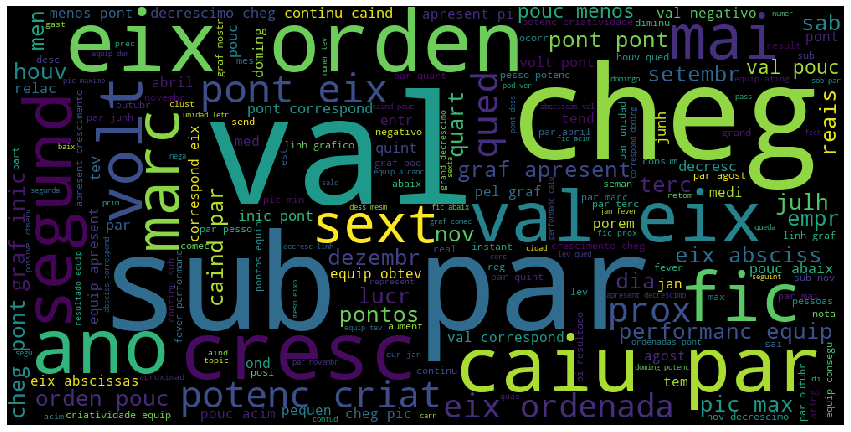

In [0]:
text = [str(value) for _, value in captions.items()]
unique_string=(" ").join(text)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("word_cloud_captions"+".png", bbox_inches='tight')
plt.show()
plt.close()

###Deep Learning Model

####Loading Data


#####Functions

Functions to model the document so that we can embed in the network

In [0]:
# load clean captions into memory
def load_clean_captions(filename, dataset):
  # load document
  doc = load_doc(filename)
  # {path_image:description}
  captions = dict()
  for line in doc.split('\n'):
    # split line by white space
    tokens = line.split()
		# split id from description
    image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
    if image_id in dataset:
      # create list
      if image_id not in captions:
        captions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
      captions[image_id].append(desc)
  return captions

# load photo features
def load_photo_features(filename, dataset):
	# load all features
	all_features = load(open(filename, 'rb'))
	# filter features
	features = {k: all_features[k] for k in dataset}
	return features

# convert a dictionary of clean captions to a list of captions
def to_lines(captions):
	all_desc = list()
	for key in captions.keys():
		[all_desc.append(d) for d in captions[key]]
	return all_desc

# fit a tokenizer given caption captions
def create_tokenizer(captions):
	lines = to_lines(captions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

#####Split train test

Automaticaly split the dataset into train and test

In [0]:
X_data=np.asarray([key for key, _ in captions.items()])
num_of_rows =int( X_data.shape[0] * 0.8)
np.random.shuffle(X_data) #shuffles data to make it random
train_data = X_data[:num_of_rows] #indexes rows for training data
test_data = X_data[num_of_rows:] #indexes rows for test data
train_data.sort() # sorts data
test_data.sort()

#####Run

Run the functions to get the apropriate data to embeed in the network

In [0]:
# load train images
train = train_data
print('Dataset: %d' % len(train))

# load description from each trained image
train_captions=load_clean_captions('captions.txt', train)
print('captions: train=%d' % len(train_captions))

# photo features
train_features = load_photo_features('features.pkl', train)
print('Photos: train=%d' % len(train_features))

# prepare tokenizer
tokenizer = create_tokenizer(train_captions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

Dataset: 148
captions: train=148
Photos: train=148
Vocabulary Size: 899


####Defining the Model

#####Functions

In [0]:
# calculate the length of the description with the most words
def max_length(captions):
	lines = to_lines(captions)
	return max(len(d.split()) for d in lines)
 
# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, captions, photos, vocab_size):
	X1, X2, y = list(), list(), list()
	# walk through each image identifier
	for key, desc_list in captions.items():
		# walk through each description for the image
		for desc in desc_list:
			# encode the sequence
			seq = tokenizer.texts_to_sequences([desc])[0]
			# split one sequence into multiple X,y pairs
			for i in range(1, len(seq)):
				# split into input and output pair
				in_seq, out_seq = seq[:i], seq[i]
				# pad input sequence
				in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
				# encode output sequence
				out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
				# store
				X1.append(photos[key][0])
				X2.append(in_seq)
				y.append(out_seq)
	return np.array(X1), np.array(X2), np.array(y)
 
# define the captioning model
def define_model(vocab_size, max_length):
	# feature extractor model
	inputs1 = Input(shape=(4096,))
	fe1 = Dropout(0.5)(inputs1)
	fe2 = Dense(256, activation='relu')(fe1)
	# sequence model
	inputs2 = Input(shape=(max_length,))
	se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
	se2 = Dropout(0.5)(se1)
	se3 = LSTM(256)(se2)
	#se3 = SimpleRNN(256)(se2)
	#se3 = GRU(256)(se2)
	# decoder model
	decoder1 = add([fe2, se3])
	decoder2 = Dense(256, activation='relu')(decoder1)
	outputs = Dense(vocab_size, activation='softmax')(decoder2)
	# tie it together [image, seq] [word]
	model = Model(inputs=[inputs1, inputs2], outputs=outputs)
	model.compile(loss='categorical_crossentropy', optimizer='adam')
	# summarize model
	print(model.summary())
	plot_model(model, to_file='model.png', show_shapes=True)
	return model

#####Run

load training dataset


In [0]:
# load train data
train = train_data
print('Dataset: %d' % len(train))

# load captions cleaned
train_captions = load_clean_captions('captions.txt', train)
print('captions: train=%d' % len(train_captions))

# photo features extracted
train_features = load_photo_features('features.pkl', train)
print('Photos: train=%d' % len(train_features))

# prepare tokenizer
tokenizer = create_tokenizer(train_captions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

# determine the maximum sequence length
max_length = max_length(train_captions)
print('Description Length: %d' % max_length)

# prepare sequences
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_captions, train_features, vocab_size)




Dataset: 148
captions: train=148
Photos: train=148
Vocabulary Size: 899
Description Length: 104


load test set

In [0]:
# load test data
test = test_data
print('Dataset: %d' % len(test))

# load captions cleaned
test_captions = load_clean_captions('captions.txt', test)
print('captions: test=%d' % len(test_captions))

# photo features extracted
test_features = load_photo_features('features.pkl', test)
print('Photos: test=%d' % len(test_features))

# prepare sequences
X1test, X2test, ytest = create_sequences(tokenizer, max_length, test_captions, test_features, vocab_size)


Dataset: 38
captions: test=38
Photos: test=38


fit model

In [0]:
# define the model
model = define_model(vocab_size, max_length)

# define checkpoint callback
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# fit model
model.fit([X1train, X2train], ytrain, epochs=100, verbose=2, callbacks=[checkpoint], validation_data=([X1test, X2test], ytest))


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 104)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 104, 256)     230144      input_3[0][0]                    
______________________________________________________________________________

KeyboardInterrupt: ignored

####Evaluate Model


#####Functions

Check model result after training

In [0]:
# map an integer to a word to get back the word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None
 
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = np.argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text

# evaluate the skill of the model using bleu
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
	actual, predicted = list(), list()
	# step over the whole set
	for key, desc_list in descriptions.items():
		# generate description
		yhat = generate_desc(model, tokenizer, photos[key], max_length)
		# store actual and predicted
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

#####Run

In [0]:
# run script to get the minimal loss
print('Get menor')
menor,_=subprocess.check_output(['./scriptMenor.sh']).decode("utf-8").split('\n')

# load the model
print('Get filename')
filename = '/content/{}'.format(menor)
print('Get model')
model = load_model(filename)

# evaluate model
print('Get evaluate')
evaluate_model(model, test_captions, test_features, tokenizer, max_length)

####New captions

#####Run

Run the real caption from an image

In [0]:
# load training dataset
train = train_data
print('Dataset: %d' % len(train))

# captions
train_captions = load_clean_captions('captions.txt', train)
print('captions: train=%d' % len(train_captions))

# prepare tokenizer
tokenizer = create_tokenizer(train_captions)

# save the tokenizer
dump(tokenizer, open('tokenizer.pkl', 'wb'))
 
# load the tokenizer
tokenizer = load(open('tokenizer.pkl', 'rb'))

# pre-define the max sequence length (from training)
max_length = 118

# load the model
model = load_model('/content/{}'.format(menor))

# load and prepare the photograph
photo = extract_features_one_photo('/content/base/Imagens/Wilder/imagem47.jpg')

# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)